In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

Let's see if the techniques explained in the openCV watershed tutorial can be applied to a slightly more complicated image of corn grains (https://docs.opencv.org/3.1.0/d3/db4/tutorial_py_watershed.html). 

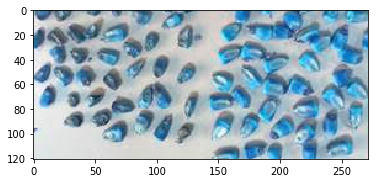

In [13]:
#Load the image 
grains = cv2.imread('grains.jpg')
plt.imshow(grains)
plt.show()

Begin with the approximation of the real image. Following the tutorial, I'll stick to the same binarization technique.

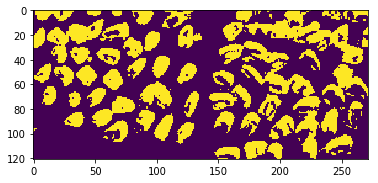

In [15]:
gray_scale = cv2.cvtColor(grains,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray_scale,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(thresh)
plt.show()

At this point, it can already be seen that the lights and shadows of the corn grains make for a more difficult task than the coins. The approximation is not as perfect as the one on the example, but let's move forward and see what happens. 

The removal of white noises, might help to paint a clearer picture. However, it must be taken into account that some grains have been identifyied as white noise and thus disappearead from our approximation. 

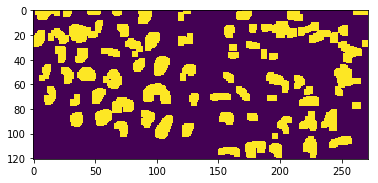

In [16]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

plt.imshow(opening)
plt.show()

The following step would be to identify: 
* Foreground area
* Background area
* Unknown area

Since grains are touching with each other, it's better to apply distance transform instead of erosion (that would simply remove the borders of the grains). This process will allow us to know what is for sure a grain.

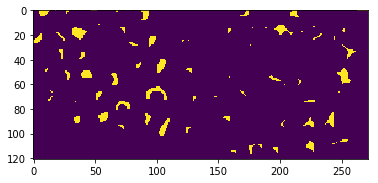

In [36]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0) #The 0.5 coefficient allows to 
#customize the radius of the distance transform
plt.imshow(sure_fg)
plt.show()

To obtain the area that we know for sure they are not grains, we use dilation (increasing the boundaries into the background). Sure background is represented in the darker, blackish, colour.

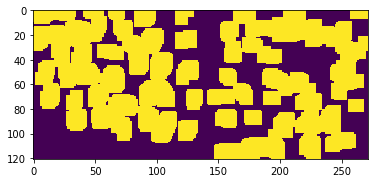

In [37]:
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
plt.imshow(sure_bg)
plt.show() 

Knowing the foreground and background, we can easily obtain the unknown area by simply substracting foreground from background.

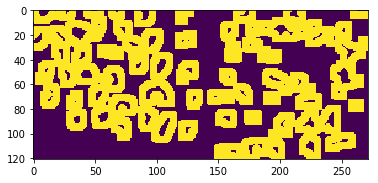

In [38]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(unknown)
plt.show()

Now that the different areas are identified , we can proceed to mark the image before the use of watershed. 

NOTE: cv2.connectedComponents() marks unknown regions as 0, and known regions starting from 1. Therefore, we'll need to manually mark the background as 1. 

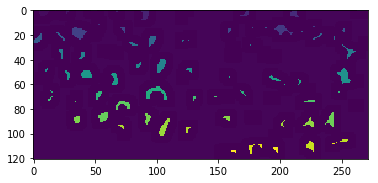

In [39]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

plt.imshow(markers)
plt.show()

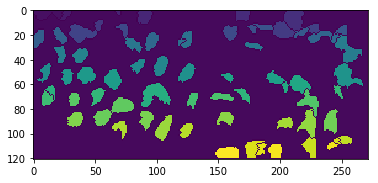

In [40]:
#Apply watershed
markers = cv2.watershed(grains,markers)
plt.imshow(markers)
plt.show()

## FINAL RESULT

As it can be seen, we have some success in identifying grains. However, the result is not very satisfying and more work should be done to fine-tune this process. 

If further improving was not possible, probably this technique should be discarded altogether and try to find another one in order to recognise the grains. 

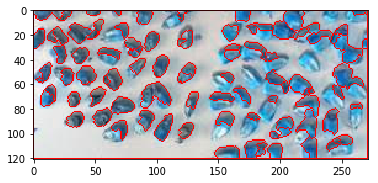

In [41]:
grains[markers == -1] = [255,0,0]
plt.imshow(grains)
plt.show()